<div style='font-size:100%;'>
    <a id='import'></a>
    <h1 style='color: gray; font-weight: bold; font-family: Cascadia code;'>
        <center>Importing the necessary libraries</center>
    </h1>
</div>

In [1]:
import tensorflow as tf
import cv2
import matplotlib.pyplot as plt
import os
from IPython.display import Image
import tensorflow.keras.backend as K
import splitfolders
import pandas as pd
import seaborn as sns
os.chdir('D:\\Saikat Sheet\\Lung Cancer Detection')

<div style='font-size:100%;'>
    <a id='preprocess'></a>
    <h1 style='color: gray; font-weight: bold; font-family: Cascadia code;'>
        <center>Data Pre-processing</center>
    </h1>
</div>

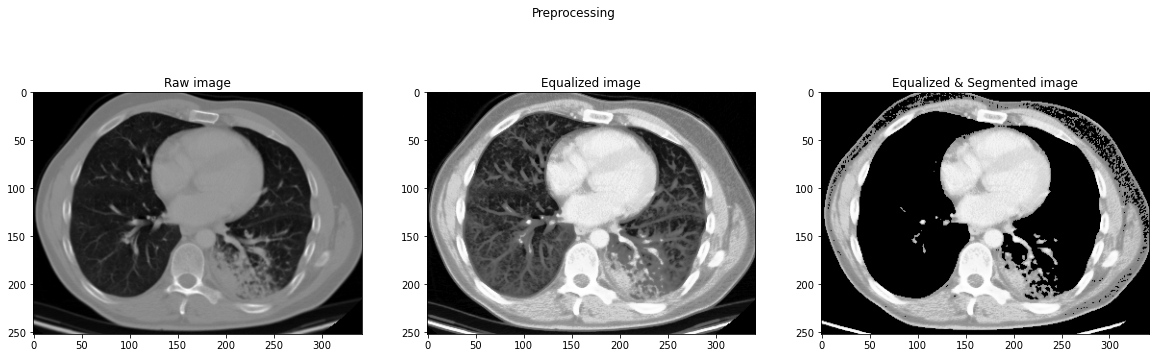

In [2]:
img = cv2.imread('D:\\Saikat Sheet\\Lung Cancer Detection\\rawData\\squamous.cell.carcinoma\\squamous.cell.carcinoma1.png', 0)
equalizedImage = cv2.equalizeHist(img)
e, segmentedImage = cv2.threshold(equalizedImage, 128, 255, cv2.THRESH_TOZERO)

plt.figure(figsize=(20, 6))

ax1 = plt.subplot(1, 3, 1)
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
ax1.set_title('Raw image')

ax2 = plt.subplot(1, 3, 2)
plt.imshow(cv2.cvtColor(equalizedImage, cv2.COLOR_BGR2RGB))
ax2.set_title('Equalized image')

ax3 = plt.subplot(1, 3, 3)
plt.imshow(cv2.cvtColor(segmentedImage, cv2.COLOR_BGR2RGB))
ax3.set_title('Equalized & Segmented image')

plt.suptitle('Preprocessing')

plt.show()

In [3]:
print(os.getcwd(), os.listdir())
DIR = 'D:\\Saikat Sheet\\Lung Cancer Detection\\rawData'
CATS = ['adenocarcinoma', 'large.cell.carcinoma', 'normal', 'squamous.cell.carcinoma']

DEST_DIR = 'D:\\Saikat Sheet\\Lung Cancer Detection\\data'

D:\Saikat Sheet\Lung Cancer Detection ['CNN.h5', 'img', 'MOBILENET.H5', 'rawData', 'VGG16.h5']


In [4]:
if not os.path.exists(DEST_DIR):
    !mkdir data && cd data && mkdir cancerous && mkdir non-cancerous

for category in CATS:
    path = os.path.join(DIR, category)
    for image in os.listdir(path):
        curr = os.path.join(path, image)
        img = cv2.imread(curr, 0)
        equalizedImage = cv2.equalizeHist(img)
        e, segmentedImage = cv2.threshold(equalizedImage, 128, 255, cv2.THRESH_TOZERO)
        if category == 'normal':
            imgDest = curr.replace('D:\\Saikat Sheet\\Lung Cancer Detection\\rawData\\normal', 'D:\\Saikat Sheet\\Lung Cancer Detection\\data\\non-cancerous')
            cv2.imwrite(imgDest, segmentedImage)
        else:
            imgDest = curr.replace('D:\\Saikat Sheet\\Lung Cancer Detection\\rawData\\adenocarcinoma', 'D:\\Saikat Sheet\\Lung Cancer Detection\\data\\cancerous')
            imgDest = imgDest.replace('D:\\Saikat Sheet\\Lung Cancer Detection\\rawData\\large.cell.carcinoma', 'D:\\Saikat Sheet\\Lung Cancer Detection\\data\\cancerous')
            imgDest = imgDest.replace('D:\\Saikat Sheet\\Lung Cancer Detection\\rawData\\squamous.cell.carcinoma', 'D:\\Saikat Sheet\\Lung Cancer Detection\\data\\cancerous')
            cv2.imwrite(imgDest, segmentedImage)
print("Processed data directory created successfully at", DEST_DIR)

Processed data directory created successfully at D:\Saikat Sheet\Lung Cancer Detection\data


<div style='font-size:100%;'>
    <a id='comparison'></a>
    <h1 style='color: gray; font-weight: bold; font-family: Cascadia code;'>
        <center>Comparison between processed and unprocessed image</center>
    </h1>
</div>

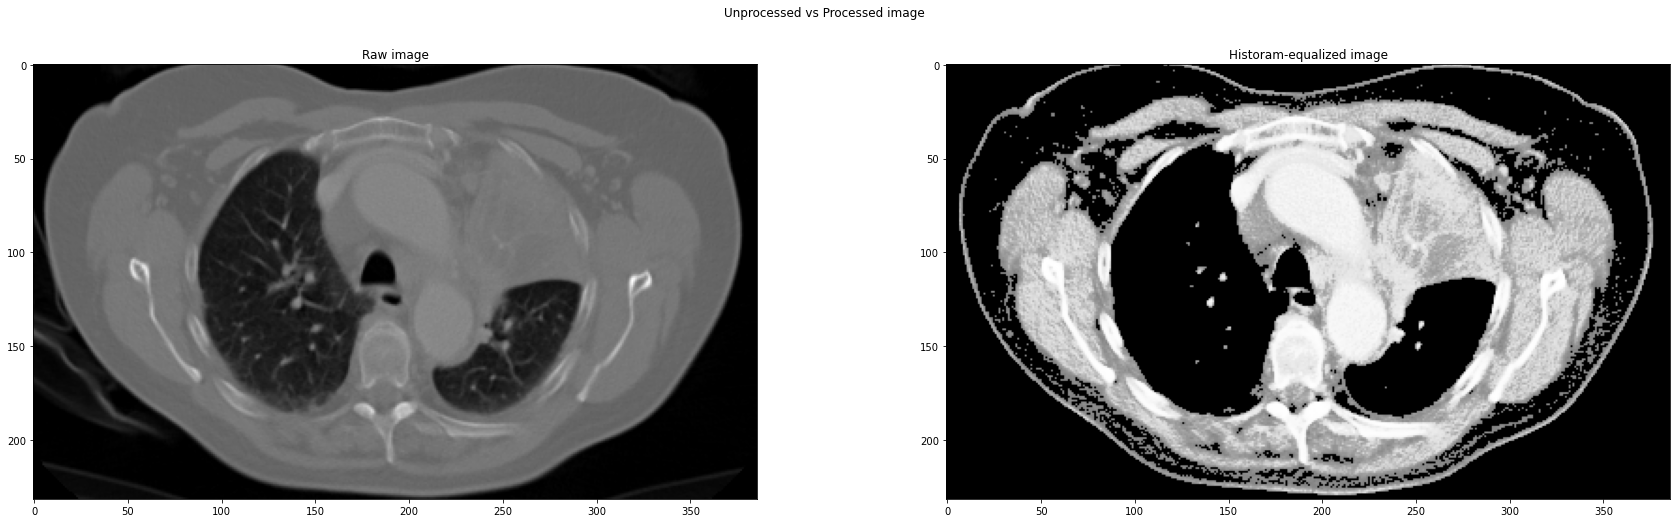

In [5]:
plt.figure(figsize=(30, 8))
plt.subplot(1, 2, 1)
plt.imshow(cv2.imread(os.path.join(DIR, CATS[0], 'adenocarcinoma10.png')))
plt.title('Raw image')
plt.subplot(1, 2, 2)
plt.imshow(cv2.imread(os.path.join(DEST_DIR,'cancerous', 'adenocarcinoma10.png')))
plt.title('Historam-equalized image')
plt.suptitle('Unprocessed vs Processed image')
plt.show()

<div style='font-size:100%;'>
    <a id='split'></a>
    <h1 style='color: gray; font-weight: bold; font-family: Cascadia code;'>
        <center>Splitting the processed images</center>
    </h1>
</div>

In [6]:
FINAL_DIR = './processedData'

splitfolders.ratio(DEST_DIR, output=FINAL_DIR, seed=69420, ratio=(.7, 0.1,0.2)) 

Copying files: 1000 files [00:06, 161.68 files/s]


In [7]:
BATCH_SIZE=4


train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale = 1./255, validation_split = 0.2,                  
                                                                rotation_range=5,
                                                                width_shift_range=0.2,
                                                                height_shift_range=0.2,
                                                                shear_range=0.2,
                                                                horizontal_flip=True,
                                                                vertical_flip=True,
                                                                fill_mode='nearest'
                                                                )

valid_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale = 1./255, validation_split = 0.2)

test_datagen  = tf.keras.preprocessing.image.ImageDataGenerator(rescale = 1./255)

In [8]:
train_dataset  = train_datagen.flow_from_directory(directory = './processedData/train',
                                                   target_size = (224,224),
                                                   class_mode = 'binary',
                                                   batch_size = 32)

Found 699 images belonging to 2 classes.


In [9]:
valid_dataset = valid_datagen.flow_from_directory(directory = './processedData/val',
                                                  target_size = (224,224),
                                                  class_mode = 'binary',
                                                  batch_size = 32)

Found 99 images belonging to 2 classes.


In [10]:
test_dataset = test_datagen.flow_from_directory(directory = './processedData/test',
                                                  target_size = (224,224),
                                                  class_mode = 'binary',
                                                  batch_size = 32)

Found 202 images belonging to 2 classes.


<div style='font-size:100%;'>
    <a id='nn'></a>
    <h1 style='color: gray; font-weight: bold; font-family: Cascadia code;'>
        <center>Neural nets</center>
    </h1>
</div>

In [11]:
def F1(y_true, y_pred): #taken from old keras source code
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

METRICS = [
      tf.keras.metrics.BinaryAccuracy(name='Accuracy'),
      tf.keras.metrics.Precision(name='Precision'),
      tf.keras.metrics.Recall(name='Recall'),  
      tf.keras.metrics.AUC(name='AUC'),
      F1,
]

<h1 align="center" ><a id='cnn'><b>CNN<b></a></h1>

In [12]:
CNN = tf.keras.Sequential()
CNN.add(tf.keras.layers.Conv2D(filters=16, kernel_size=(3, 3), activation='relu', input_shape=(224, 224, 3)))
CNN.add(tf.keras.layers.Conv2D(filters=36, kernel_size=(3, 3), activation='relu'))
CNN.add(tf.keras.layers.MaxPool2D(pool_size=(2, 2)))
CNN.add(tf.keras.layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
CNN.add(tf.keras.layers.MaxPool2D(pool_size=(2, 2)))
CNN.add(tf.keras.layers.Conv2D(filters=128, kernel_size=(3, 3), activation='relu'))
CNN.add(tf.keras.layers.MaxPool2D(pool_size=(2, 2)))
CNN.add(tf.keras.layers.Dropout(rate=0.25))
CNN.add(tf.keras.layers.Flatten())
CNN.add(tf.keras.layers.Dense(units=64, activation='relu'))
CNN.add(tf.keras.layers.Dropout(rate=0.25))
CNN.add(tf.keras.layers.Dense(units=1, activation='sigmoid'))

CNN.summary()

CNN.compile(optimizer='adam',
              loss=tf.keras.losses.binary_crossentropy, metrics=METRICS)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 16)      448       
                                                                 
 conv2d_1 (Conv2D)           (None, 220, 220, 36)      5220      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 110, 110, 36)     0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 108, 108, 64)      20800     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 54, 54, 64)       0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 52, 52, 128)       7

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.


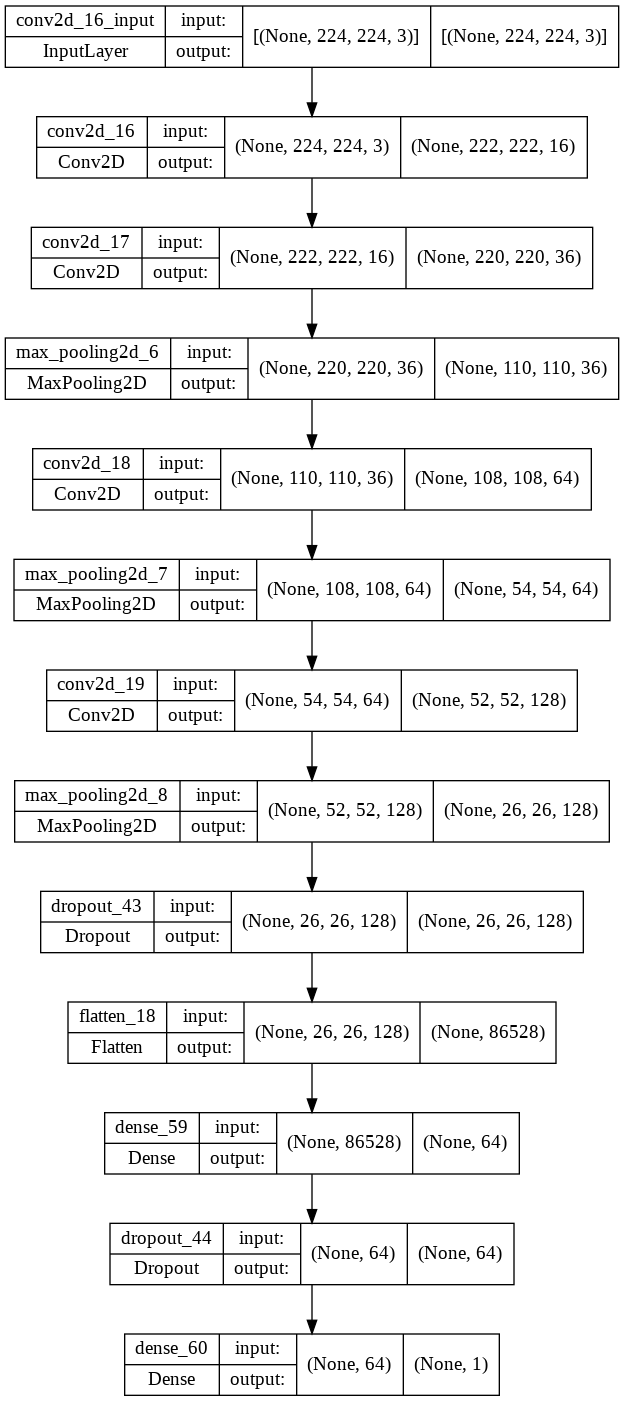

In [13]:
tf.keras.utils.plot_model(CNN, to_file='D:\\Saikat Sheet\\Lung Cancer Detection\\img\\CNN.png', show_shapes=True,show_layer_names=True)
Image(filename='D:\\Saikat Sheet\\Lung Cancer Detection\\img\\CNN.png')

In [14]:
lrd = tf.keras.callbacks.ReduceLROnPlateau(monitor = 'val_loss',patience = 3,verbose = 1,factor = 0.50, min_lr = 1e-7)

mcp = tf.keras.callbacks.ModelCheckpoint('CNN.h5', save_best_only=True, mode='auto', monitor='val_accuracy')

es = tf.keras.callbacks.EarlyStopping(verbose=1, patience=3)

CNN.fit(train_dataset,validation_data=valid_dataset, epochs = 36,verbose = 1, callbacks=[lrd,mcp,es], shuffle=True)

Epoch 1/36
22/22 [==============================] - 67s 3s/step - loss: 0.6407 - Accuracy: 0.7597 - Precision: 0.1786 - Recall: 0.0333 - AUC: 0.4901 - F1: 0.0130 - val_loss: 0.5042 - val_Accuracy: 0.7879 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00 - val_AUC: 0.7250 - val_F1: 0.0000e+00 - lr: 0.0010
Epoch 2/36
22/22 [==============================] - 59s 3s/step - loss: 0.4934 - Accuracy: 0.7854 - Precision: 0.0000e+00 - Recall: 0.0000e+00 - AUC: 0.6612 - F1: 0.0000e+00 - val_loss: 0.4318 - val_Accuracy: 0.7879 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00 - val_AUC: 0.8672 - val_F1: 0.0000e+00 - lr: 0.0010
Epoch 3/36
22/22 [==============================] - 59s 3s/step - loss: 0.4460 - Accuracy: 0.7854 - Precision: 0.0000e+00 - Recall: 0.0000e+00 - AUC: 0.7776 - F1: 0.0000e+00 - val_loss: 0.3490 - val_Accuracy: 0.7879 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00 - val_AUC: 0.9005 - val_F1: 0.0000e+00 - lr: 0.0010
Epoch 4/36
22/22 [==============================]

In [15]:
CNN_scores = CNN.evaluate(test_dataset, verbose=1)

7/7 [==============================] - 4s 592ms/step - loss: 0.2869 - Accuracy: 0.9158 - Precision: 0.8462 - Recall: 0.7500 - AUC: 0.9371 - F1: 0.8016


<h1 align="center" ><a id='vgg16'><b>VGG16<b></a></h1>

In [16]:
VGG16_base = tf.keras.applications.VGG16(input_shape=(224,224,3),include_top=False,weights="imagenet")

for layer in VGG16_base.layers:
    layer.trainable = False

VGG16=tf.keras.Sequential()
VGG16.add(VGG16_base)
VGG16.add(tf.keras.layers.Dropout(0.5))
VGG16.add(tf.keras.layers.Flatten())
VGG16.add(tf.keras.layers.BatchNormalization())
VGG16.add(tf.keras.layers.Dense(32,kernel_initializer='he_uniform'))
VGG16.add(tf.keras.layers.BatchNormalization())
VGG16.add(tf.keras.layers.Activation('relu'))
VGG16.add(tf.keras.layers.Dropout(0.5))
VGG16.add(tf.keras.layers.Dense(32,kernel_initializer='he_uniform'))
VGG16.add(tf.keras.layers.BatchNormalization())
VGG16.add(tf.keras.layers.Activation('relu'))
VGG16.add(tf.keras.layers.Dropout(0.5))
VGG16.add(tf.keras.layers.Dense(32,kernel_initializer='he_uniform'))
VGG16.add(tf.keras.layers.BatchNormalization())
VGG16.add(tf.keras.layers.Activation('relu'))
VGG16.add(tf.keras.layers.Dense(1,activation='sigmoid'))

VGG16.summary()

VGG16.compile(optimizer='rmsprop',
              loss=tf.keras.losses.binary_crossentropy, metrics=METRICS)

A local file was found, but it seems to be incomplete or outdated because the auto file hash does not match the original value of 6d6bbae143d832006294945121d1f1fc so we will re-download the data.
58889256/58889256 [==============================] - 61s 1us/step
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 dropout_2 (Dropout)         (None, 7, 7, 512)         0         
                                                                 
 flatten_1 (Flatten)         (None, 25088)             0         
                                                                 
 batch_normalization (BatchN  (None, 25088)            100352    
 ormalization)                                                   
                                                        

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.


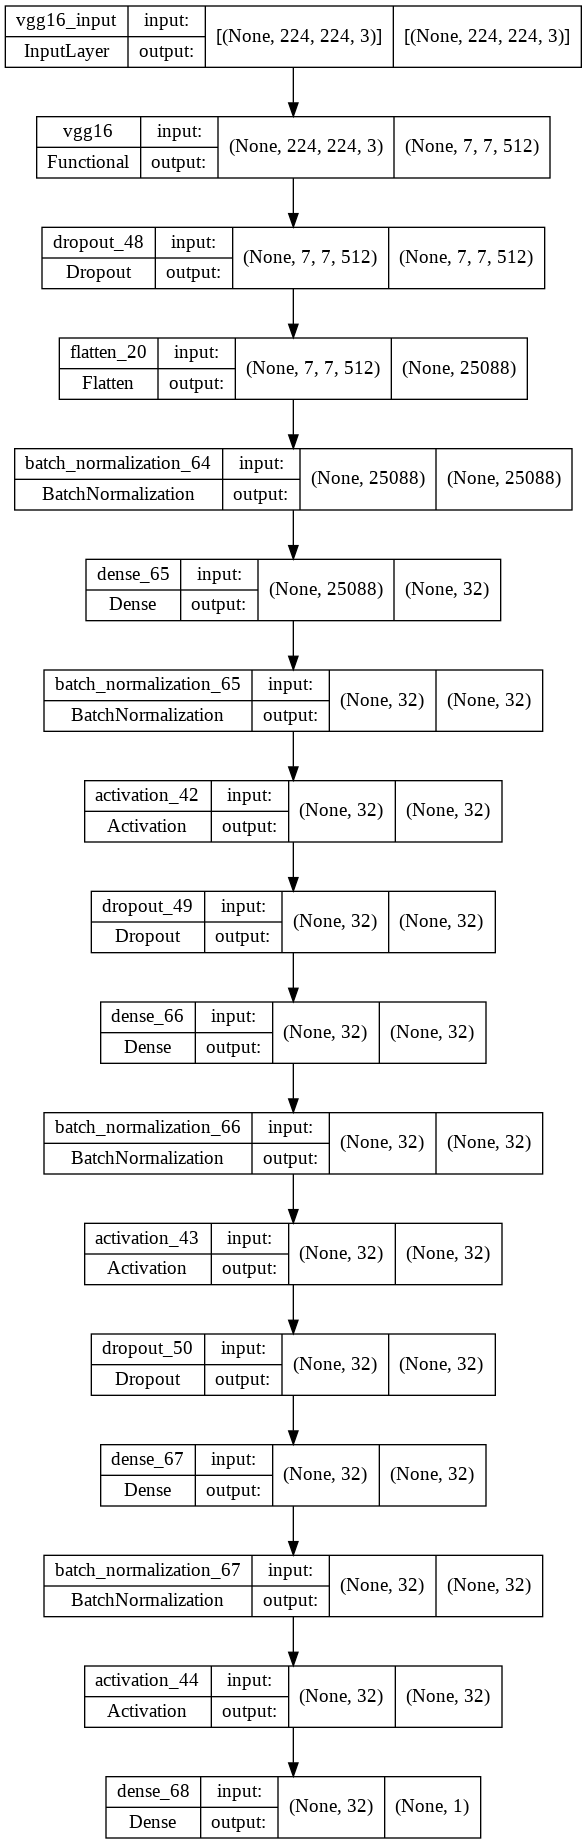

In [17]:
tf.keras.utils.plot_model(VGG16, to_file='D:\\Saikat Sheet\\Lung Cancer Detection\\img\\VGG16.png', show_shapes=True,show_layer_names=True)
Image(filename='D:\\Saikat Sheet\\Lung Cancer Detection\\img\\VGG16.png')

In [18]:
lrd = tf.keras.callbacks.ReduceLROnPlateau(monitor = 'val_loss',patience = 3,verbose = 1,factor = 0.50, min_lr = 1e-7)

mcp = tf.keras.callbacks.ModelCheckpoint('VGG16.h5', save_best_only=True, mode='auto', monitor='val_accuracy')

es = tf.keras.callbacks.EarlyStopping(verbose=1, patience=3)

VGG16.fit(train_dataset,validation_data=valid_dataset, epochs = 36,verbose = 1, callbacks=[lrd,mcp,es], shuffle=True)

Epoch 1/36
22/22 [==============================] - 186s 8s/step - loss: 0.8139 - Accuracy: 0.5638 - Precision: 0.2914 - Recall: 0.7165 - AUC: 0.6361 - F1: 0.3556 - val_loss: 0.5444 - val_Accuracy: 0.7879 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00 - val_AUC: 0.6990 - val_F1: 0.0000e+00 - lr: 0.0010
Epoch 2/36
22/22 [==============================] - 182s 8s/step - loss: 0.6269 - Accuracy: 0.6581 - Precision: 0.3428 - Recall: 0.6467 - AUC: 0.7230 - F1: 0.4391 - val_loss: 0.3456 - val_Accuracy: 0.8485 - val_Precision: 1.0000 - val_Recall: 0.2857 - val_AUC: 0.9173 - val_F1: 0.3500 - lr: 0.0010
Epoch 3/36
22/22 [==============================] - 177s 8s/step - loss: 0.5322 - Accuracy: 0.7454 - Precision: 0.4307 - Recall: 0.5800 - AUC: 0.7648 - F1: 0.4787 - val_loss: 0.2552 - val_Accuracy: 0.8788 - val_Precision: 1.0000 - val_Recall: 0.4286 - val_AUC: 0.9606 - val_F1: 0.4333 - lr: 0.0010
Epoch 4/36
22/22 [==============================] - 176s 8s/step - loss: 0.4446 - Accuracy: 0.

Epoch 17/36
22/22 [==============================] - 188s 9s/step - loss: 0.2040 - Accuracy: 0.9242 - Precision: 0.8593 - Recall: 0.7733 - AUC: 0.9649 - F1: 0.8013 - val_loss: 0.0784 - val_Accuracy: 0.9899 - val_Precision: 1.0000 - val_Recall: 0.9524 - val_AUC: 0.9915 - val_F1: 0.9891 - lr: 0.0010
Epoch 18/36
22/22 [==============================] - 187s 9s/step - loss: 0.1697 - Accuracy: 0.9313 - Precision: 0.8542 - Recall: 0.8200 - AUC: 0.9766 - F1: 0.8269 - val_loss: 0.0723 - val_Accuracy: 0.9899 - val_Precision: 1.0000 - val_Recall: 0.9524 - val_AUC: 0.9945 - val_F1: 0.7353 - lr: 0.0010
Epoch 19/36
22/22 [==============================] - 185s 8s/step - loss: 0.2049 - Accuracy: 0.9170 - Precision: 0.8286 - Recall: 0.7733 - AUC: 0.9653 - F1: 0.7780 - val_loss: 0.0681 - val_Accuracy: 0.9899 - val_Precision: 1.0000 - val_Recall: 0.9524 - val_AUC: 0.9930 - val_F1: 0.9868 - lr: 0.0010
Epoch 20/36
22/22 [==============================] - 185s 8s/step - loss: 0.1793 - Accuracy: 0.9313 - P

In [19]:
VGG16_scores = VGG16.evaluate(test_dataset, verbose=1)

7/7 [==============================] - 45s 6s/step - loss: 0.0707 - Accuracy: 0.9752 - Precision: 0.8980 - Recall: 1.0000 - AUC: 0.9988 - F1: 0.9561


<h1 align="center" ><a id='mobilenet'><b>MobileNet<b></a></h1>

In [20]:
MOBILENET_base =  tf.keras.applications.MobileNet(input_shape=(224,224,3), include_top= False)

for layer in MOBILENET_base.layers:
    layer.trainable = False

MOBILENET=tf.keras.Sequential()
MOBILENET.add(MOBILENET_base)
MOBILENET.add(tf.keras.layers.Dropout(0.5))
MOBILENET.add(tf.keras.layers.Flatten())
MOBILENET.add(tf.keras.layers.BatchNormalization())
MOBILENET.add(tf.keras.layers.Dense(32,kernel_initializer='he_uniform'))
MOBILENET.add(tf.keras.layers.BatchNormalization())
MOBILENET.add(tf.keras.layers.Activation('relu'))
MOBILENET.add(tf.keras.layers.Dropout(0.5))
MOBILENET.add(tf.keras.layers.Dense(32,kernel_initializer='he_uniform'))
MOBILENET.add(tf.keras.layers.BatchNormalization())
MOBILENET.add(tf.keras.layers.Activation('relu'))
MOBILENET.add(tf.keras.layers.Dropout(0.5))
MOBILENET.add(tf.keras.layers.Dense(32,kernel_initializer='he_uniform'))
MOBILENET.add(tf.keras.layers.BatchNormalization())
MOBILENET.add(tf.keras.layers.Activation('relu'))
MOBILENET.add(tf.keras.layers.Dense(1,activation='sigmoid'))

MOBILENET.summary()

MOBILENET.compile(optimizer='rmsprop',
              loss=tf.keras.losses.binary_crossentropy, metrics=METRICS)

17225924/17225924 [==============================] - 18s 1us/step
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenet_1.00_224 (Functio  (None, 7, 7, 1024)       3228864   
 nal)                                                            
                                                                 
 dropout_5 (Dropout)         (None, 7, 7, 1024)        0         
                                                                 
 flatten_2 (Flatten)         (None, 50176)             0         
                                                                 
 batch_normalization_4 (Batc  (None, 50176)            200704    
 hNormalization)                                                 
                                                                 
 dense_6 (Dense)             (None, 32)                1605664   
                                                      

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.


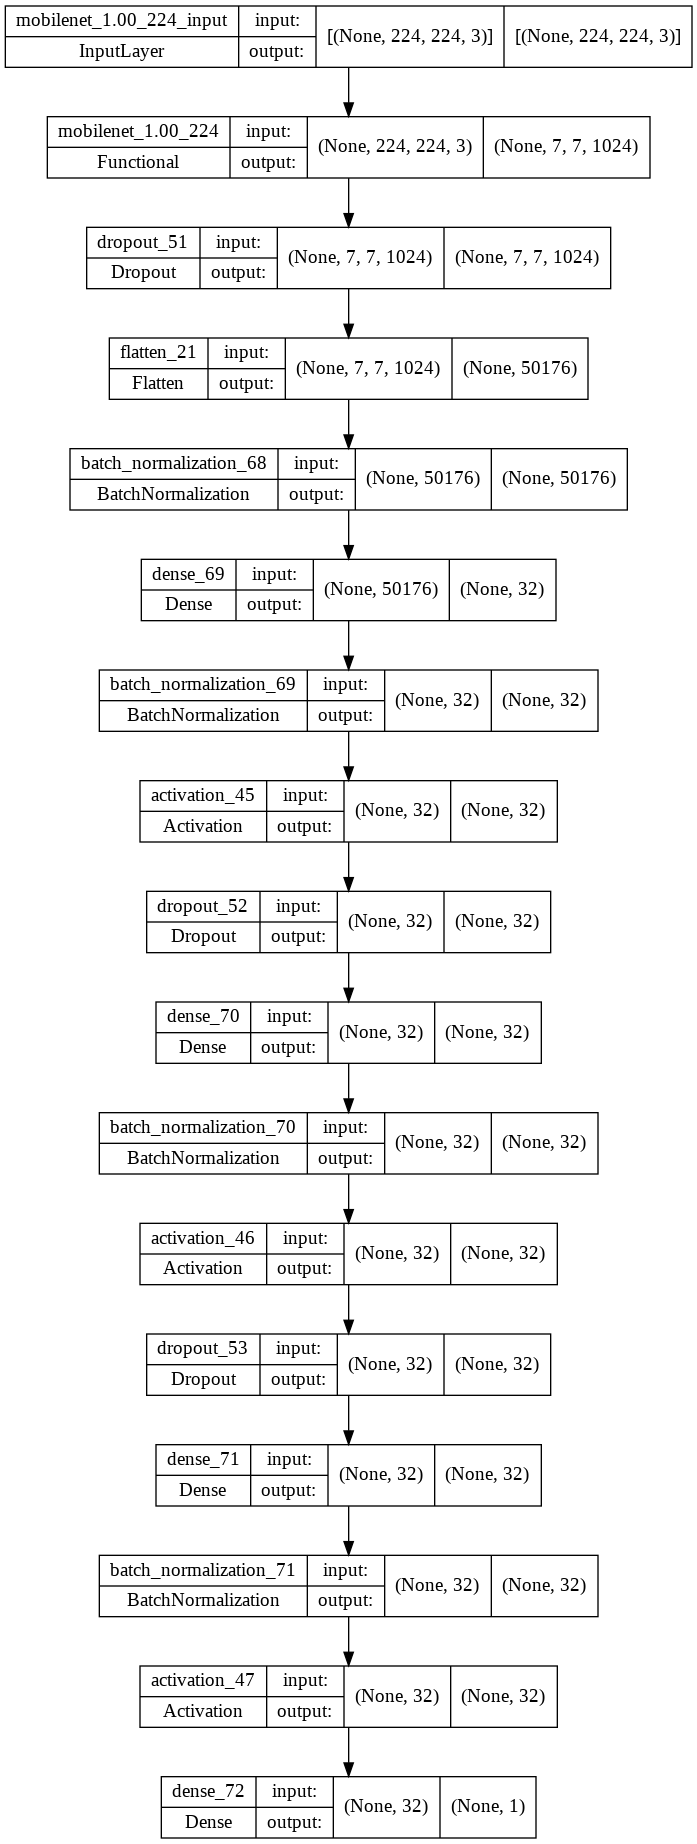

In [21]:
tf.keras.utils.plot_model(MOBILENET, to_file='D:\\Saikat Sheet\\Lung Cancer Detection\\img\\MOBILENET.png', show_shapes=True,show_layer_names=True)
Image(filename='D:\\Saikat Sheet\\Lung Cancer Detection\\img\\MOBILENET.png')

In [22]:
lrd = tf.keras.callbacks.ReduceLROnPlateau(monitor = 'val_loss',patience = 3,verbose = 1,factor = 0.50, min_lr = 1e-7)

mcp = tf.keras.callbacks.ModelCheckpoint('MOBILENET.h5', save_best_only=True, mode='auto', monitor='val_accuracy')

es = tf.keras.callbacks.EarlyStopping(verbose=1, patience=3)

MOBILENET.fit(train_dataset,validation_data=valid_dataset,epochs = 36,verbose = 1, callbacks=[lrd, mcp, es], shuffle=True)

Epoch 1/36
22/22 [==============================] - 28s 1s/step - loss: 0.5668 - Accuracy: 0.8069 - Precision: 0.5595 - Recall: 0.4845 - AUC: 0.7494 - F1: 0.3602 - val_loss: 0.3452 - val_Accuracy: 0.8889 - val_Precision: 1.0000 - val_Recall: 0.4762 - val_AUC: 0.8150 - val_F1: 0.5284 - lr: 0.0010
Epoch 2/36
22/22 [==============================] - 22s 973ms/step - loss: 0.4928 - Accuracy: 0.7940 - Precision: 0.5333 - Recall: 0.3200 - AUC: 0.6956 - F1: 0.3919 - val_loss: 0.2979 - val_Accuracy: 0.8687 - val_Precision: 0.7222 - val_Recall: 0.6190 - val_AUC: 0.9048 - val_F1: 0.7278 - lr: 0.0010
Epoch 3/36
22/22 [==============================] - 22s 988ms/step - loss: 0.4058 - Accuracy: 0.8526 - Precision: 0.7527 - Recall: 0.4667 - AUC: 0.8322 - F1: 0.5518 - val_loss: 0.1918 - val_Accuracy: 0.9495 - val_Precision: 0.9000 - val_Recall: 0.8571 - val_AUC: 0.9921 - val_F1: 0.6702 - lr: 0.0010
Epoch 4/36
22/22 [==============================] - 22s 973ms/step - loss: 0.3597 - Accuracy: 0.8612 - 

In [23]:
MOBILENET_scores = MOBILENET.evaluate(test_dataset, verbose=1)

7/7 [==============================] - 4s 604ms/step - loss: 0.0525 - Accuracy: 0.9802 - Precision: 0.9348 - Recall: 0.9773 - AUC: 0.9991 - F1: 0.9619


<div style='font-size:100%;'>
    <a id='example'></a>
    <h1 style='color: gray; font-weight: bold; font-family: Cascadia code;'>
        <center> Example: Prediction vs Truth </center>
    </h1>
</div></center>

1/1 [==============================] - 0s 49ms/step


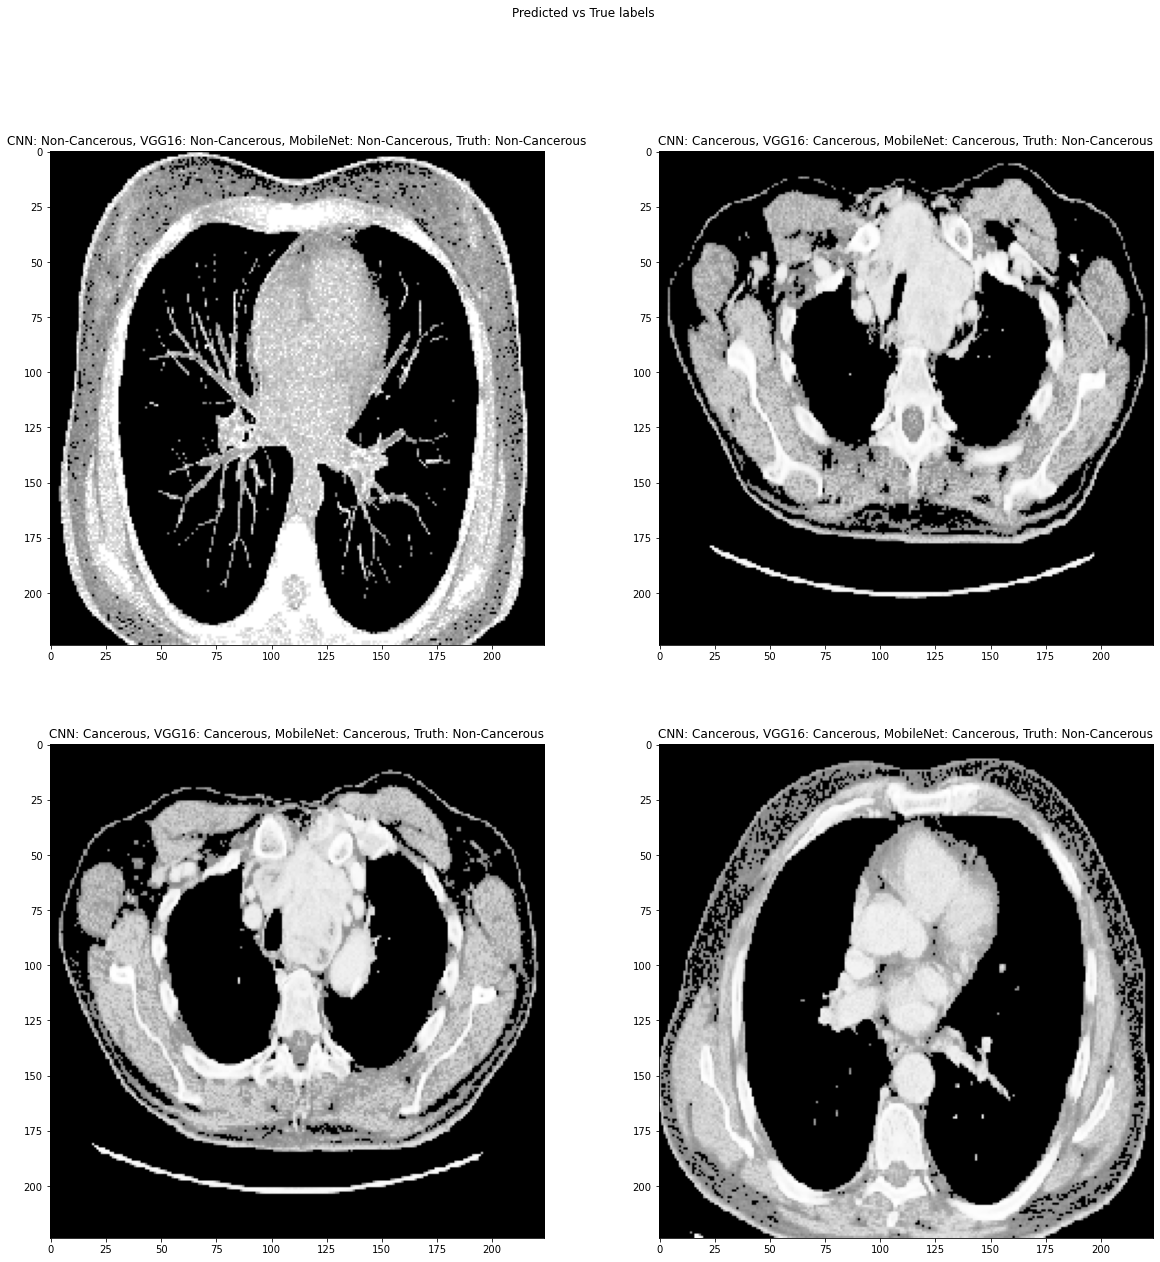

In [24]:
batch = next(test_dataset)

def predAll(batch, i):
  label_dict = {0: 'Cancerous', 1: 'Non-Cancerous'}
  cnnPred = 0 if CNN.predict(batch[0][i].reshape(-1, 224, 224, 3)) < 0.5 else 1
  vgg16Pred = 0 if VGG16.predict(batch[0][i].reshape(-1, 224, 224, 3)) < 0.5 else 1
  mobilenetPred = 0 if MOBILENET.predict(batch[0][i].reshape(-1, 224, 224, 3)) < 0.5 else 1
  
  return f'CNN: {label_dict[cnnPred]}, VGG16: {label_dict[vgg16Pred]}, MobileNet: {label_dict[mobilenetPred]}, Truth: {label_dict[int(batch[1][0])]}'


plt.figure(figsize=(20, 20))

ax1 = plt.subplot(2, 2, 1)
plt.imshow(batch[0][0])
label = predAll(batch, 0)
ax1.set_title(label)


ax2 = plt.subplot(2, 2, 2)
plt.imshow(batch[0][1])
label = predAll(batch, 1)
ax2.set_title(label)

ax3 = plt.subplot(2, 2, 3)
plt.imshow(batch[0][2])
label = predAll(batch, 2)
ax3.set_title(label)

ax4 = plt.subplot(2, 2, 4)
plt.imshow(batch[0][3])
label = predAll(batch, 3)
ax4.set_title(label)


plt.suptitle('Predicted vs True labels')
plt.show()


In [25]:
eval = [CNN_scores, VGG16_scores, MOBILENET_scores]
eval

[[0.2868814766407013,
  0.9158415794372559,
  0.8461538553237915,
  0.75,
  0.9371404647827148,
  0.8016234040260315],
 [0.07065854966640472,
  0.9752475023269653,
  0.8979591727256775,
  1.0,
  0.9988492131233215,
  0.956060528755188],
 [0.0525159128010273,
  0.9801980257034302,
  0.9347826242446899,
  0.9772727489471436,
  0.9991369843482971,
  0.9619047045707703]]

<div style='font-size:100%;'>
    <a id='analysis'></a>
    <h1 style='color: gray; font-weight: bold; font-family: Cascadia code;'>
        <center> Comparative analysis of the models </center>
    </h1>
</div></center>

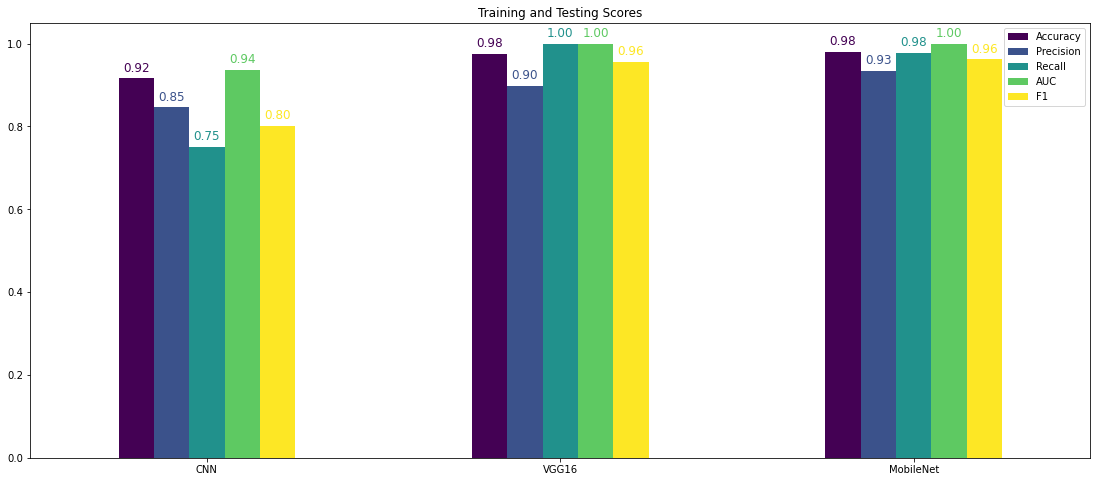

In [26]:
indices = ['CNN', 'VGG16', 'MobileNet']
scores = pd.DataFrame({'Accuracy': [item[1] for item in eval],'Precision': [item[2] for item in eval], 'Recall': [item[3] for item in eval], 'AUC': [item[4] for item in eval], 'F1': [item[5] for item in eval]}, index=indices)
plot = scores.plot.bar(figsize=(19, 8), rot=0, cmap='viridis')
plt.title('Training and Testing Scores')
plot.bar_label(plot.containers[0], padding=4, color='#440154', fontsize=12, fmt='%.2f')
plot.bar_label(plot.containers[1], padding=4, color='#3b528b', fontsize=12, fmt='%.2f')
plot.bar_label(plot.containers[2], padding=4, color='#21918c', fontsize=12, fmt='%.2f')
plot.bar_label(plot.containers[3], padding=4, color='#5ec962', fontsize=12, fmt='%.2f')
plot.bar_label(plot.containers[4], padding=4, color='#fde725', fontsize=12, fmt='%.2f')

plt.show()

In [27]:
scores

,Accuracy,Precision,Recall,AUC,F1
CNN,0.915842,0.846154,0.750000,0.937140,0.801623
VGG16,0.975248,0.897959,1.000000,0.998849,0.956061
MobileNet,0.980198,0.934783,0.977273,0.999137,0.961905
